## La Liga Goalkeepers

In [95]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.patheffects as path_effects
import matplotlib.font_manager as fm
import matplotlib.colors as mcolors
from matplotlib import cm
from highlight_text import fig_text, ax_text
from matplotlib.colors import LinearSegmentedColormap, Normalize
import matplotlib.gridspec as gridspec

from PIL import Image
import urllib
import json
import os

In [2]:
font_path = "../assets/fonts"
for x in os.listdir(font_path):
    for y in os.listdir(f"{font_path}/{x}"):
        if y.split(".")[-1] == "ttf":
            fm.fontManager.addfont(f"{font_path}/{x}/{y}")
            try:
                fm.FontProperties(weight=y.split("-")[-1].split(".")[0].lower(), fname=y.split("-")[0])
            except Exception:
                continue

plt.style.use("../assets/stylesheets/soc_base.mplstyle")

## The Data

In [24]:
df = pd.read_csv('data/10102022_laliga_gk.csv', index_col=0)
df['date'] = pd.to_datetime(df['date'])

In [114]:
df_grouped = df.groupby(['playerName', 'playerId', 'teamId', 'teamName'])['minutes'].sum().reset_index()
df_grouped = df_grouped[df_grouped['minutes'] >= 90*35].sort_values(by='minutes', ascending=False)
# Remove Diego Lopez because he isn't a starter anymore
df_grouped = df_grouped[df_grouped['playerId'] != 41466].reset_index(drop=True)

In [115]:
df_grouped

,playerName,playerId,teamId,teamName,minutes
0,Jeremias Ledesma,486981,8385,Cadiz,4050
1,David Soria,581919,8305,Getafe,4045
2,Jan Oblak,177126,9906,Atletico Madrid,4044
3,Alex Remiro,616539,8560,Real Sociedad,3780
4,Marc-Andre ter Stegen,184554,8634,Barcelona,3780
5,Thibaut Courtois,170323,8633,Real Madrid,3690
6,Unai Simon,660625,8315,Athletic Club,3690
7,Geronimo Rulli,245555,10205,Villarreal,3600
8,Matias Dituro,592412,9910,Celta Vigo,3420
9,Sergio Herrera,683762,8371,Osasuna,3420


In [100]:
df_filtered = df[df['playerId'].isin(df_grouped['playerId'])].sort_values(by='date').reset_index(drop=True)
df_filtered['rolling_xGOT'] = df_filtered.groupby(['playerId', 'playerName', 'teamId'])['xGOT'].cumsum()
df_filtered['rolling_goals'] = df_filtered.groupby(['playerId', 'playerName', 'teamId'])['goals_conceded'].cumsum()
df_filtered['rolling_diff'] = df_filtered['rolling_xGOT'] - df_filtered['rolling_goals']

## The Viz

In [146]:
def plot_gk_xgot(ax, player_highlight, label_x=True, label_y=False):
    ax.grid(ls='--', color='#efe9e6', zorder=2)

    for x in df_filtered['playerId'].unique():
        aux_df = df_filtered[df_filtered['playerId'] == x].reset_index(drop=True)
        if x == player_highlight:
            if aux_df['rolling_diff'].iloc[-1] > 0:
                color = '#336699'
                aux_text = '+'
            else:
                color = '#DA4167'
                aux_text = ''
            ax.plot(aux_df.index, aux_df['rolling_diff'], lw=1.5, color=color, zorder=5, markevery=[-1], marker='o', ms=6, mfc='white')
        else:
            ax.plot(aux_df.index, aux_df['rolling_diff'], lw=.75, color='grey', alpha=0.25)

    ax.set_xlim(ax.get_xlim()[0], ax.get_xlim()[1])
    ax.set_ylim(ax.get_ylim()[0], ax.get_ylim()[1])
    ax.plot([ax.get_xlim()[0], ax.get_xlim()[1]], [0,0], color='black', ls='dashed', lw=1)
    # -- Fancy fillbetween
    ax.fill_between(x=[ax.get_xlim()[0], ax.get_xlim()[1]], 
                    y1=0, y2=ax.get_ylim()[1], color='#336699', alpha=0.05, ec='None', hatch='......', zorder=1)
    ax.fill_between(x=[ax.get_xlim()[0], ax.get_xlim()[1]], 
                    y1=0, y2=ax.get_ylim()[0], color='#DA4167', alpha=0.05, ec='None', hatch='......', zorder=1)
    # -- Highlighted player annotation
    highlight_df = df_filtered[df_filtered['playerId'] == player_highlight].reset_index(drop=True)
    text_ = ax.annotate(
        xy=(highlight_df.index[-1], highlight_df['rolling_diff'].iloc[-1]),
        text=f"{aux_text} {highlight_df['rolling_diff'].iloc[-1]:.1f}",
        xytext=(10,5),
        textcoords='offset points',
        weight='bold',
        ha='center',
        va='center',
        color=color,
        size=7,
        zorder=3
    )
    text_.set_path_effects(
        [path_effects.Stroke(linewidth=1.5, foreground='white'), path_effects.Normal()]
    )
    if label_x:
        ax.set_xlabel('Match index')
    else:
        ax.set_xticklabels([])
    if label_y:
        ax.set_ylabel('Cum. xGOT minus goals conceded')
    else:
        ax.set_yticklabels([])
    return ax

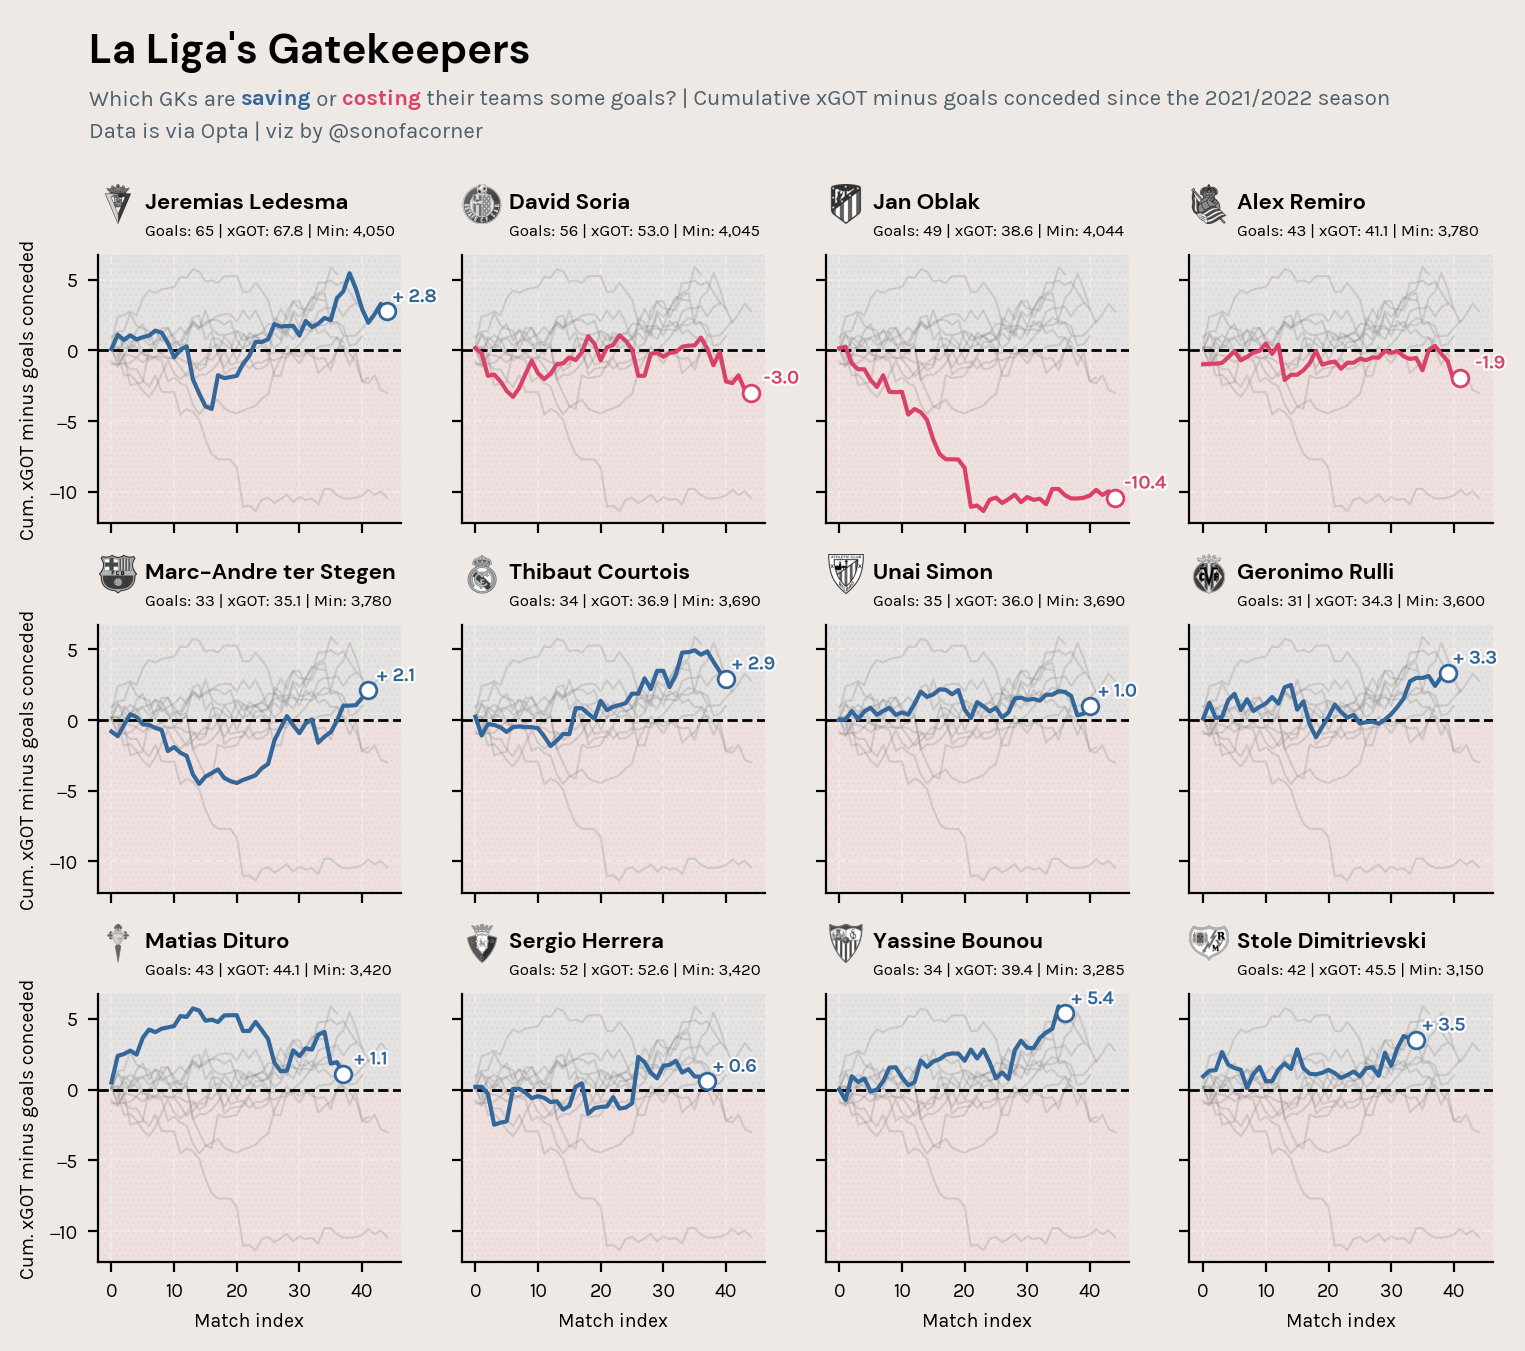

In [148]:
fig = plt.figure(figsize=(9, 7), dpi = 200)
nrows = 6
ncols = 4
gspec = gridspec.GridSpec(
    ncols=ncols, nrows=nrows, figure=fig, 
    height_ratios = [(1/nrows)*2.6 if x % 2 != 0 else (1/nrows)/2.6 for x in range(nrows)], hspace=0.2
)

plt.rcParams['font.size'] = 7
plt.rcParams['xtick.labelsize'] = 7
plt.rcParams['ytick.labelsize'] = 7
plt.rcParams['hatch.linewidth'] = 0.5

plot_counter = 0
logo_counter = 0
for row in range(nrows):
    for col in range(ncols):
        if row % 2 != 0:
            ax = plt.subplot(
                gspec[row, col],
                facecolor = "#EFE9E6"
            )
            playerId = df_grouped['playerId'].iloc[plot_counter]
            if col == 0:
                label_y = True
            else:
                label_y = False
            if row == 5:
                label_x = True
            else:
                label_x = False
            
            plot_gk_xgot(ax, playerId, label_x, label_y)           
            plot_counter += 1
        else:
            teamId = df_grouped['teamId'].iloc[logo_counter]
            playerName = df_grouped['playerName'].iloc[logo_counter]
            minutes_played = df_grouped['minutes'].iloc[logo_counter]
            goals_conceded = df_filtered[df_filtered['playerName'] == playerName]['goals_conceded'].sum()
            xGOT_conceded = df_filtered[df_filtered['playerName'] == playerName]['xGOT'].sum()
            fotmob_url = 'https://images.fotmob.com/image_resources/logo/teamlogo/'
            logo_ax = plt.subplot(
                gspec[row,col],
                anchor = 'NW', facecolor = '#EFE9E6'
            )
            club_icon = Image.open(urllib.request.urlopen(f'{fotmob_url}{teamId:.0f}.png')).convert('LA')
            logo_ax.imshow(club_icon)
            logo_ax.axis('off')
            # # -- Add the team name
            ax_text(
                x = 1.2, 
                y = .8,
                s = f'<{playerName}>\nGoals: {goals_conceded:.0f} | xGOT: {xGOT_conceded:.1f} | Min: {minutes_played:,.0f}',
                ax = logo_ax, 
                highlight_textprops=[{'weight':'bold', 'font':'DM Sans', 'size':'8'}],
                font = 'Karla', 
                ha = 'left', 
                size = 6, 
                annotationbbox_kw = {'xycoords':'axes fraction'}
            )
            logo_counter += 1

fig_text(
    x=0.12, y=.96, 
    s='La Liga\'s Gatekeepers',
    va='bottom', ha='left',
    fontsize=15, color='black', font='DM Sans', weight='bold'
)
fig_text(
	x=0.12, y=.91, 
    s='Which GKs are <saving> or <costing> their teams some goals? | Cumulative xGOT minus goals conceded since the 2021/2022 season\nData is via Opta | viz by @sonofacorner',
    highlight_textprops=[{'weight':'bold', 'color': '#336699'}, {'weight':'bold', 'color': '#DA4167'}],
	va='bottom', ha='left',
	fontsize=8, color='#4E616C', font='Karla'
)

plt.savefig(
	"figures/10102022_laliga_gk.png",
	dpi = 600,
	facecolor = "#EFE9E6",
	bbox_inches="tight",
    edgecolor="none",
	transparent = False
)

plt.savefig(
	"figures/10102022_laliga_gk_tr.png",
	dpi = 600,
	facecolor = "none",
	bbox_inches="tight",
    edgecolor="none",
	transparent = True
)